# Loading Data

In [1]:
from collections import defaultdict
from shutil import copy, copytree, rmtree

In [21]:
import os
def setup_training_data(txtfile, source, destination, food_list=['cheesecake', 'baklava', 'ramen']):
    # In order we have: txt with file name, image source folder, destination folder, list of foods to copy in
    # food list defaults to cheesecake, baklava, and ramen if not indicated
    food_types = defaultdict(list)
    with open(txtfile, "r") as file:
        lines = [line.strip() for line in file.readlines()]
        for l in lines:
            food_type = l.split("/")
            if food_type[0] in food_list:
                food_types[food_type[0]].append(food_type[1] + ".jpg")
    
    for food in food_types.keys():
        print("  " + food, end="  ")
        if not os.path.exists(os.path.join(destination, food)):
            os.makedirs(os.path.join(destination, food))
        for n in food_types[food]:
            copy(os.path.join(source, food, n), os.path.join(destination, food, n))        

In [22]:
setup_training_data('train.txt', 'images', 'train')

  baklava    cheesecake    ramen  

In [26]:
setup_training_data('test.txt', 'images', 'test')

  baklava    cheesecake    ramen  

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [27]:
image_size = (235, 235)

train_gen = data_gen.flow_from_directory('train', target_size=image_size) # class_mode default categorical
test_gen = data_gen.flow_from_directory('test', target_size=image_size) # default batch_size is 32

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [28]:
print(train_gen.class_indices)

{'baklava': 0, 'cheesecake': 1, 'ramen': 2}


# Creating Model

## Using InceptionV3

In [29]:
from tensorflow.keras.applications import InceptionV3
input_shape = (235, 235, 3) # 235, 235 stands for w and h. The 3 stands for the three channels for RGB
inception_model = InceptionV3(weights="imagenet", input_shape=input_shape, include_top=False)
inception_model.trainable = False # freeze weights

## Creating the head

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

model = Sequential()
model.add(inception_model)
#model.add(Conv2D(32, 2, activation='relu')) # filters=32, kernel_size=(2,2)
#model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation="relu")) # 64 units
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 21,934,115
Trainable params: 131,331
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='food_model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

In [38]:
history = model.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30
71/71 [==============================] - 46s 644ms/step - loss: 0.2449 - accuracy: 0.9044 - val_loss: 0.1565 - val_accuracy: 0.9467

Epoch 00001: val_loss improved from inf to 0.15651, saving model to food_model.hdf5
Epoch 2/30
71/71 [==============================] - 45s 642ms/step - loss: 0.1795 - accuracy: 0.9324 - val_loss: 0.2746 - val_accuracy: 0.8973

Epoch 00002: val_loss did not improve from 0.15651
Epoch 3/30
71/71 [==============================] - 47s 657ms/step - loss: 0.1656 - accuracy: 0.9382 - val_loss: 0.1539 - val_accuracy: 0.9413

Epoch 00003: val_loss improved from 0.15651 to 0.15391, saving model to food_model.hdf5
Epoch 4/30
71/71 [==============================] - 45s 630ms/step - loss: 0.1339 - accuracy: 0.9471 - val_loss: 0.1371 - val_accuracy: 0.9507

Epoch 00004: val_loss improved from 0.15391 to 0.13709, saving model to food_model.hdf5
Epoch 5/30
71/71 [==============================] - 45s 634ms/step - loss: 0.1091 - accuracy: 0.9627 - val_loss: 

## Post Analysis

### Graph Accuracy and Loss

<AxesSubplot:>

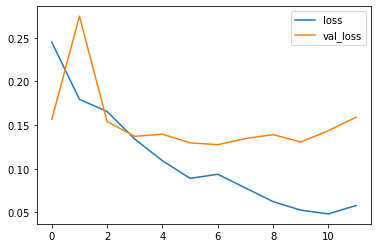

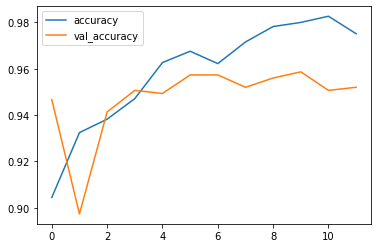

In [39]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()